In [6]:
from __future__ import absolute_import, division, print_function
import numpy as np
import sqlalchemy as sql
from rmexp import dbutils, config, dataset_analysis as analysis
from rmexp.schema import models
from logzero import logger

In [7]:
from ikea.fsm import IkeaFSM

In [3]:
# Identify key frame ids that trigger state changes using IkeaFSM
# ikea has trace 1-14 for now
def get_ikea_gt_inst_idx():
    print('Below are ikea dataset detected states')
    app = 'ikea'
    trace_ids = list(range(1, 15))
    dataset_state_transitions = {}
    for trace_id in trace_ids:
        print('--------------------trace {}-----------'.format(trace_id))
        fsm = IkeaFSM(im_h=200, im_w=300)
        ss_df = analysis.get_ss_df(app, trace_id)
        transition_fids = []
        for _, row in ss_df.iterrows():
            if fsm.process_ss(row['val']):
                print(row['index'], ':', fsm.current_state)
                transition_fids.append(row['index'])
        dataset_state_transitions[trace_id] = transition_fids
    return dataset_state_transitions

ikea_gt_inst_idx = get_ikea_gt_inst_idx()

Below are ikea dataset detected states
--------------------trace 1-----------
194 : base
759 : pipe
1207 : shade
2105 : buckle
2757 : blackcircle
3133 : shadebase
4014 : bulb
4781 : bulbtop
--------------------trace 2-----------
615 : base
--------------------trace 3-----------
222 : base
969 : pipe
1523 : shade
--------------------trace 4-----------
207 : base
847 : pipe
1126 : shade
2012 : buckle
2784 : blackcircle
3106 : shadebase
3773 : bulb
4425 : bulbtop
--------------------trace 5-----------
151 : base
--------------------trace 6-----------
190 : base
786 : pipe
1434 : shade
--------------------trace 7-----------
113 : base
1079 : pipe
1824 : shade
2607 : buckle
3233 : blackcircle
3697 : shadebase
4420 : bulb
5570 : bulbtop
--------------------trace 8-----------
442 : base
1509 : pipe
2124 : shade
--------------------trace 9-----------
188 : base
689 : pipe
1374 : shade
2227 : buckle
--------------------trace 10-----------
387 : base
1130 : pipe
1607 : shade
--------------------

# Candidate Traces to Use

Following traces went through the entire task states:

1, 4, 7, 11, 12, 13, 14

Using 1, 7, 11, 12 as we have IMU suppression predicitons for them.

## Save state transition frame ids to database

In [10]:
candidates = [1, 7, 11, 12]
for trace_id in candidates:
    analysis.upload_ikea_gt_inst_idx(trace_id, ikea_gt_inst_idx[trace_id], store=True)

[I 190912 16:29:20.739 dataset_analysis:106] ikea trace 1: {"inst_idx": [194, 759, 1207, 2105, 2757, 3133, 4014, 4781]}
[I 190912 16:29:20.749 dataset_analysis:106] ikea trace 7: {"inst_idx": [113, 1079, 1824, 2607, 3233, 3697, 4420, 5570]}
[I 190912 16:29:20.757 dataset_analysis:106] ikea trace 11: {"inst_idx": [196, 985, 1841, 3031, 4427, 5021, 5182, 6700]}
[I 190912 16:29:20.764 dataset_analysis:106] ikea trace 12: {"inst_idx": [273, 1098, 2411, 3409, 5020, 6050, 6451, 7240]}


## Get Stage Length for Duty Cycle Estimation

In [19]:
stage_num = 0
stage_lens = []
for trace_id in candidates:
    gt_inst_idx = ikea_gt_inst_idx[trace_id]
    stage_lens.append(gt_inst_idx[0])
    stage_lens.extend(np.diff(gt_inst_idx))
stage_lens_in_sec = np.array(stage_lens) / 30.0
print('avg of stage length (in secs): ', np.mean(stage_lens_in_sec))
print('std of stage length (in secs): ', np.std(stage_lens_in_sec))

avg of stage length (in secs):  25.303124999999998
std of stage length (in secs):  12.881043240226981


In [20]:
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


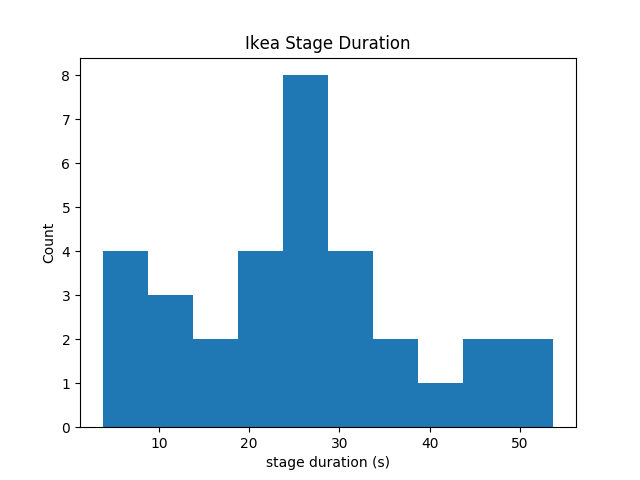

Text(0.5,1,'Ikea Stage Duration')

In [21]:
%matplotlib notebook

plt.figure()
plt.hist(stage_lens_in_sec);
plt.ylabel('Count');
plt.xlabel('stage duration (s)');
plt.title('Ikea Stage Duration')